# **Preprocesamiento**

## **Filtro para eliminar la neblina**

Referencia: http://kaiminghe.com/publications/pami10dehaze.pdf 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import math
import numpy as np
import pandas as pd
import cv2
import time
from tqdm import tqdm
from fastai.vision import *

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Node(object):
    def __init__(self,x,y,value):
        self.x = x
        self.y = y
        self.value = value

    def printInfo(self):
        print('%s:%s:%s' %(self.x,self.y,self.value))
        

## **getMinChannel()**

In [ ]:
# Valida las dimensiones de la imagen, y calcula el mínimo entre los 3 canales

def getMinChannel(img):

##Valida las dimensiones de la imagen
    if len(img.shape)==3 and img.shape[2]==3:
        pass
    else:
        print("bad image shape, input must be color image")
        return None
##Calcula el mínimo entre los 3 canales
    return np.min(img, axis=2)

##Genera una objeto matriz de solo 2 dimensiones, que sería una imagen en blanco y negro

## **getDarkChannel()**

In [ ]:
def getDarkChannel(img,blockSize = 3):

## Valida que el objeto sea de 2 dimensiones
    if len(img.shape)==2:
        pass
    else:
        print("bad image shape, input image must be two demensions")
        return None

## Valida el tabaño del bloque para que no sea tan pequeño
    if blockSize % 2 == 0 or blockSize < 3:
        print('blockSize is not odd or too small')
        return None

    A = int((blockSize-1)/2) #AddSize

    H = img.shape[0] + blockSize - 1
    W = img.shape[1] + blockSize - 1

    imgMiddle = 255 * np.ones((H,W))    

    imgMiddle[A:H-A, A:W-A] = img
    
    imgDark = np.zeros_like(img, np.uint8)    
    
    localMin = 255
    for i in range(A, H-A):
        for j in range(A, W-A):
            x = range(i-A, i+A+1)
            y = range(j-A, j+A+1)
            imgDark[i-A,j-A] = np.min(imgMiddle[x,y])                            
            
    return imgDark

In [ ]:
def getAtomsphericLight(darkChannel,img,meanMode = False, percent = 0.001):

    size = darkChannel.shape[0]*darkChannel.shape[1]
    height = darkChannel.shape[0]
    width = darkChannel.shape[1]

    nodes = []

    for i in range(0,height):
        for j in range(0,width):
            oneNode = Node(i,j,darkChannel[i,j])
            nodes.append(oneNode)	

    nodes = sorted(nodes, key = lambda node: node.value,reverse = True)

    atomsphericLight = 0

    if int(percent*size) == 0:
        for i in range(0,3):
            if img[nodes[0].x,nodes[0].y,i] > atomsphericLight:
                atomsphericLight = img[nodes[0].x,nodes[0].y,i]
        return atomsphericLight

    if meanMode:
        sum = 0
        for i in range(0,int(percent*size)):
            for j in range(0,3):
                sum = sum + img[nodes[i].x,nodes[i].y,j]
        atomsphericLight = int(sum/(int(percent*size)*3))
        return atomsphericLight

    for i in range(0,int(percent*size)):
        for j in range(0,3):
            if img[nodes[i].x,nodes[i].y,j] > atomsphericLight:
                atomsphericLight = img[nodes[i].x,nodes[i].y,j]
    return atomsphericLight

In [ ]:
def getRecoverScene(img, omega=0.95, t0=0.1, blockSize=15, meanMode=False, percent=0.001, refine=True):

    imgGray = getMinChannel(img)
    imgDark = getDarkChannel(imgGray, blockSize = blockSize)
    atomsphericLight = getAtomsphericLight(imgDark,img,meanMode = meanMode,percent= percent)

    imgDark = np.float64(imgDark)
    transmission = 1 - omega * imgDark / atomsphericLight

    transmission[transmission<0.1] = 0.1     
    
    if refine:        
        normI = (img - img.min()) / (img.max() - img.min())  # normalize I
        transmission = guided_filter(normI, transmission, r=40, eps=1e-3)

    sceneRadiance = np.zeros(img.shape)
    img = np.float64(img)
    
    for i in range(3):        
        SR = (img[:,:,i] - atomsphericLight)/transmission + atomsphericLight
                  
        SR[SR>255] = 255
        SR[SR<0] = 0                    
        sceneRadiance[:,:,i] = SR  
            
    sceneRadiance = np.uint8(sceneRadiance)

    return sceneRadiance

## Guided Image Filtering

In [ ]:

from itertools import combinations_with_replacement
from collections import defaultdict

import numpy as np
from numpy.linalg import inv

R, G, B = 0, 1, 2 


def boxfilter(I, r):
      
    M, N = I.shape
    dest = np.zeros((M, N))

    sumY = np.cumsum(I, axis=0)
    dest[:r + 1] = sumY[r: 2 * r + 1]
    dest[r + 1:M - r] = sumY[2 * r + 1:] - sumY[:M - 2 * r - 1]
    dest[-r:] = np.tile(sumY[-1], (r, 1)) - sumY[M - 2 * r - 1:M - r - 1]

    sumX = np.cumsum(dest, axis=1)
    dest[:, :r + 1] = sumX[:, r:2 * r + 1]
    dest[:, r + 1:N - r] = sumX[:, 2 * r + 1:] - sumX[:, :N - 2 * r - 1]
    dest[:, -r:] = np.tile(sumX[:, -1][:, None], (1, r)) - \
        sumX[:, N - 2 * r - 1:N - r - 1]

    return dest


def guided_filter(I, p, r=40, eps=1e-3):
 
    M, N = p.shape
    base = boxfilter(np.ones((M, N)), r)

    means = [boxfilter(I[:, :, i], r) / base for i in range(3)]
    mean_p = boxfilter(p, r) / base
    means_IP = [boxfilter(I[:, :, i] * p, r) / base for i in range(3)]
    covIP = [means_IP[i] - means[i] * mean_p for i in range(3)]

    var = defaultdict(dict)
    for i, j in combinations_with_replacement(range(3), 2):
        var[i][j] = boxfilter(
            I[:, :, i] * I[:, :, j], r) / base - means[i] * means[j]

    a = np.zeros((M, N, 3))
    for y, x in np.ndindex(M, N):
        #         rr, rg, rb
        # Sigma = rg, gg, gb
        #         rb, gb, bb
        Sigma = np.array([[var[R][R][y, x], var[R][G][y, x], var[R][B][y, x]],
                          [var[R][G][y, x], var[G][G][y, x], var[G][B][y, x]],
                          [var[R][B][y, x], var[G][B][y, x], var[B][B][y, x]]])
        cov = np.array([c[y, x] for c in covIP])
        a[y, x] = np.dot(cov, inv(Sigma + eps * np.eye(3)))  # eq 14

    b = mean_p - a[:, :, R] * means[R] - \
        a[:, :, G] * means[G] - a[:, :, B] * means[B]

    q = (boxfilter(a[:, :, R], r) * I[:, :, R] + boxfilter(a[:, :, G], r) *
         I[:, :, G] + boxfilter(a[:, :, B], r) * I[:, :, B] + boxfilter(b, r)) / base

    return q

In [ ]:
labels_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DiplomadoIA/M1_AplicacionesConVisionArtificial/Proyecto_Amazonia/Datos_Entrenamiento/train_v2.csv')

In [ ]:
'/content/drive/My Drive/Colab Notebooks/DiplomadoIA/M1_AplicacionesConVisionArtificial/Proyecto_Amazonia/Datos_Entrenamiento/train-jpg/'+filename

'/content/drive/My Drive/Colab Notebooks/DiplomadoIA/M1_AplicacionesConVisionArtificial/Proyecto_Amazonia/Datos_Entrenamiento/train-jpg/train_3795.jpg'

In [ ]:
filename = 'train_{}.jpg'.format(104)
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/DiplomadoIA/M1_AplicacionesConVisionArtificial/Proyecto_Amazonia/Datos_Entrenamiento/train-jpg/'+filename)  #0-255    
img.shape

len(img.shape)

3

In [ ]:
hazy_img_idx = [104, 3007, 3794, 23710, 38469]

for i in hazy_img_idx:    
    filename = 'train_{}.jpg'.format(i)
    img = cv2.imread('/content/drive/My Drive/Colab Notebooks/DiplomadoIA/M1_AplicacionesConVisionArtificial/Proyecto_Amazonia/Datos_Entrenamiento/train-jpg/'+filename)  #0-255    
    
    dehazed_img1 = getRecoverScene(img, refine=True)
    dehazed_img2 = getRecoverScene(img, refine=False)

    fig = plt.figure()
    fig.set_size_inches(12, 4)
    fig.suptitle(filename + '   Tags: ' + labels_df['tags'][i], fontsize=12)

    plt.subplot(131)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.subplot(132)
    plt.imshow(cv2.cvtColor(dehazed_img1, cv2.COLOR_BGR2RGB))
    
    plt.subplot(133)
    plt.imshow(cv2.cvtColor(dehazed_img2, cv2.COLOR_BGR2RGB))
    
    plt.show()

In [ ]:
num_train = 40479

range(10445, num_train)

range(10445, 40479)

In [ ]:
num_train = 40479

for i in tqdm(range(19333, 19339)):    
    filename = 'train_{}.jpg'.format(i)
    img = cv2.imread('/content/drive/My Drive/Colab Notebooks/DiplomadoIA/M1_AplicacionesConVisionArtificial/Proyecto_Amazonia/Datos_Entrenamiento/train-jpg/'+filename)  #0-255    
    
    dehazed_img = getRecoverScene(img, refine=True)

    filename2 = 'train_dehazed_{}.jpg'.format(i)
    cv2.imwrite('/content/drive/My Drive/Colab Notebooks/DiplomadoIA/M1_AplicacionesConVisionArtificial/Proyecto_Amazonia/Datos_Entrenamiento/train-dehazed-jpg/'+filename2, dehazed_img)




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:04<00:22,  4.53s/it]

 33%|███▎      | 2/6 [00:08<00:17,  4.48s/it]

 50%|█████     | 3/6 [00:13<00:13,  4.43s/it]

 67%|██████▋   | 4/6 [00:16<00:08,  4.23s/it]

 83%|████████▎ | 5/6 [00:20<00:04,  4.16s/it]

100%|██████████| 6/6 [00:25<00:00,  4.29s/it]


In [ ]:
num_train = 40479

for i in tqdm(range(40060, num_train)):    
    filename = 'train_{}.jpg'.format(i)
    img = cv2.imread('/content/drive/My Drive/Colab Notebooks/DiplomadoIA/M1_AplicacionesConVisionArtificial/Proyecto_Amazonia/Datos_Entrenamiento/train-jpg/'+filename)  #0-255    
    
    dehazed_img = getRecoverScene(img, refine=True)

    filename2 = 'train_dehazed_{}.jpg'.format(i)
    cv2.imwrite('/content/drive/My Drive/Colab Notebooks/DiplomadoIA/M1_AplicacionesConVisionArtificial/Proyecto_Amazonia/Datos_Entrenamiento/train-dehazed-jpg/'+filename2, dehazed_img)



100%|██████████| 419/419 [34:13<00:00,  4.90s/it]


In [ ]:
data = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
        .split_none()
        .label_from_df(label_delim=' ')).databunch()

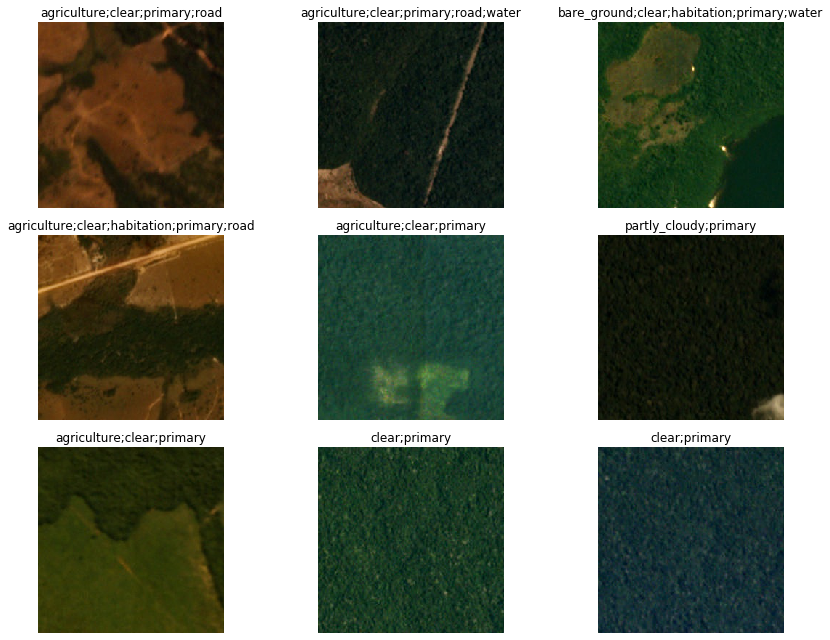

In [ ]:
data.show_batch(rows=3, figsize=(12,9))